# Custom loss functions Keras TF

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

We going to exemplify how to implement a custom loss function on MLP using the TF Keras Library.

**Data Type at Entry:** Array.

**Data Type at Output:** Array.

In [1]:
import time
import torch
import keras
import numpy as np
import pandas as pd
import torch.nn as nn
from keras.layers import Dense
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

In [3]:
def creation_batchs(n_batchs, X_train, y_train):

  N_train = len(X_train)
  N_batch = int(N_train/n_batchs) + 1

  all_X_train = []
  all_y_train = []

  for i in range(n_batchs):

    all_X_train.append(X_train[i*N_batch: (i+1)*N_batch].copy())
    all_y_train.append(y_train[i*N_batch: (i+1)*N_batch].copy())

  return all_X_train, all_y_train

### Start time of execution

In [4]:
start = time.time()

# 1. Regresion Problem

### i. Creacion of Dataset

In [5]:
X = [(i*0.1 - 20) for i in range(1, 400 + 1)]

In [6]:
y = [x**2 for x in X]

In [7]:
df = pd.DataFrame({'X': X, 'y': y})

In [8]:
df['X'] = df['X'].astype('float32')
df['y'] = df['y'].astype('float32')

In [9]:
X = df[['X']].copy()
y = df['y'].copy()

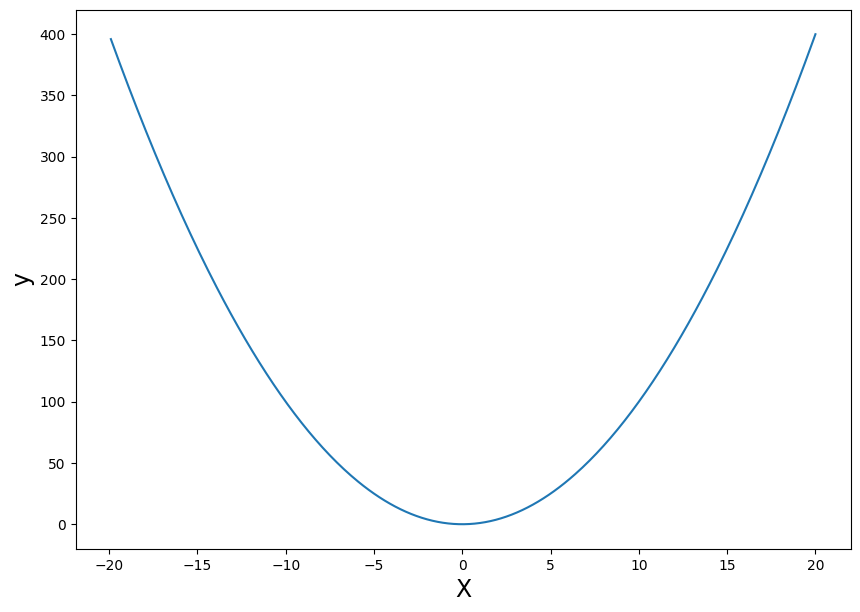

In [10]:
plt.figure(figsize = (10, 7))
plt.xlabel('X', fontsize = 17)
plt.ylabel('y', fontsize = 17)
plt.plot(X, y)
plt.show()

### ii. Split

In [11]:
n_batchs = 2

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

In [14]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [15]:
y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train = (y_train - y_train_mean)/y_train_std
y_val = (y_val - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

In [16]:
all_X_train, all_y_train = creation_batchs(n_batchs, X_train, y_train)

In [17]:
for i in range(n_batchs):
  all_X_train[i] = np.array(all_X_train[i])
  all_y_train[i] = np.array(all_y_train[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Custom Loss Function

In [18]:
from keras import ops

In [19]:
def my_loss_fn(y_true, y_pred):

  squared_difference = ops.abs(y_true - y_pred)

  return ops.mean(squared_difference, axis=-1)

# Model

### iii. Creation of model

In [20]:
def model_keras(input_size, hidden_dim_1, hidden_dim_2, output_size, lr, n_epochs):

  model = Sequential()
  model.add(Dense(hidden_dim_1, activation = 'relu', input_shape = (input_size,)))
  model.add(Dense(hidden_dim_2, activation = 'relu'))
  model.add(Dense(output_size))

  model.compile(optimizer = Adam(learning_rate = lr), loss = my_loss_fn)

  _ = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 100, verbose = 0)

  return model

### iv. Hyperparameter Tuning Jobs

In [21]:
input_size = 1
output_size = 1

all_hidden_dim_1 = [(i*2) for i in range(1, 5 + 1)]
all_hidden_dim_2 = [(i*2) for i in range(1, 5 + 1)]
all_n_epochs = [(i*100) for i in range(1, 5 + 1)]
all_lr = [(i*0.01) for i in range(1, 5 + 1)]

all_params = []

for hidden_dim_1 in all_hidden_dim_1:
  for hidden_dim_2 in all_hidden_dim_2:
    for n_epochs in all_n_epochs:
      for lr in all_lr:
        all_params.append({'hidden_dim_1': hidden_dim_1, 'hidden_dim_2': hidden_dim_2, 'n_epochs': n_epochs, 'lr': lr})

In [22]:
hidden_dim_1_col = []
hidden_dim_2_col = []

n_epochs_col = []
lr_col = []

loss_val_col = []

c = 0

start_iter = time.time()

m = 10

for params in all_params:

  c = c + 1

  hidden_dim_1 = params['hidden_dim_1']
  hidden_dim_2 = params['hidden_dim_2']

  n_epochs = params['n_epochs']
  lr = params['lr']

  model = model_keras(input_size, hidden_dim_1, hidden_dim_2, output_size, lr, n_epochs)

  y_pred_val = (model(X_val)[:, 0]).numpy()

  loss_val = ((y_pred_val - y_val)**2).mean()

  hidden_dim_1_col.append(hidden_dim_1)
  hidden_dim_2_col.append(hidden_dim_2)

  n_epochs_col.append(n_epochs)
  lr_col.append(lr)

  loss_val_col.append(loss_val)

  if (c % m) == 0:

    end_iter = time.time()
    print(f'c = {c}')
    print(print_time_execution(start_iter, end_iter, f'execute {m} iterations'))
    print('-'*70)
    start_iter = time.time()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c = 10
execute 10 iterations it takes 0 hours, 1 mins and 16 segs.
----------------------------------------------------------------------
c = 20
execute 10 iterations it takes 0 hours, 2 mins and 22 segs.
----------------------------------------------------------------------
c = 30
execute 10 iterations it takes 0 hours, 2 mins and 24 segs.
----------------------------------------------------------------------
c = 40
execute 10 iterations it takes 0 hours, 1 mins and 52 segs.
----------------------------------------------------------------------
c = 50
execute 10 iterations it takes 0 hours, 3 mins and 25 segs.
----------------------------------------------------------------------
c = 60
execute 10 iterations it takes 0 hours, 1 mins and 12 segs.
----------------------------------------------------------------------
c = 70
execute 10 iterations it takes 0 hours, 2 mins and 35 segs.
----------------------------------------------------------------------
c = 80
execute 10 iterations it ta

In [23]:
ht = pd.DataFrame()
ht['hidden_dim_1'] = hidden_dim_1_col
ht['hidden_dim_2'] = hidden_dim_2_col
ht['n_epochs'] = n_epochs_col
ht['lr'] = lr_col
ht['loss_val'] = loss_val_col

In [24]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt, _ = ht[ht['loss_val'] == ht['loss_val'].min()].iloc[0]

In [25]:
hidden_dim_1_opt = int(hidden_dim_1_opt)
hidden_dim_2_opt = int(hidden_dim_2_opt)
n_epochs_opt = int(n_epochs_opt)

In [26]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt

(8, 8, 500, 0.01)

### v. Definitive model

In [27]:
def model_keras_2(input_size, hidden_dim_1, hidden_dim_2, output_size, lr, n_epochs):

  model = Sequential()
  model.add(Dense(hidden_dim_1, activation = 'relu', input_shape = (input_size,)))
  model.add(Dense(hidden_dim_2, activation = 'relu'))
  model.add(Dense(output_size))

  model.compile(optimizer = Adam(learning_rate = lr), loss = my_loss_fn)

  hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = n_epochs, batch_size = 100)

  return model, hist

In [28]:
model, hist = model_keras_2(input_size, hidden_dim_1_opt, hidden_dim_2_opt, output_size, lr_opt, n_epochs_opt)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.8606 - val_loss: 0.7919
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8179 - val_loss: 0.7574
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7654 - val_loss: 0.7227
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7330 - val_loss: 0.6861
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6904 - val_loss: 0.6435
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6559 - val_loss: 0.5964
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5851 - val_loss: 0.5496
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5331 - val_loss: 0.4954
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4701 - val_loss: 0.4371
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4085 - val_loss: 0.3709
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3454 - val_loss: 0.2960
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2639 - val_loss: 0.2448


In [29]:
all_loss_train = np.array(hist.history['loss'])
all_loss_val = np.array(hist.history['val_loss'])
all_n_epochs = np.array([i for i in range(1, n_epochs_opt + 1)])

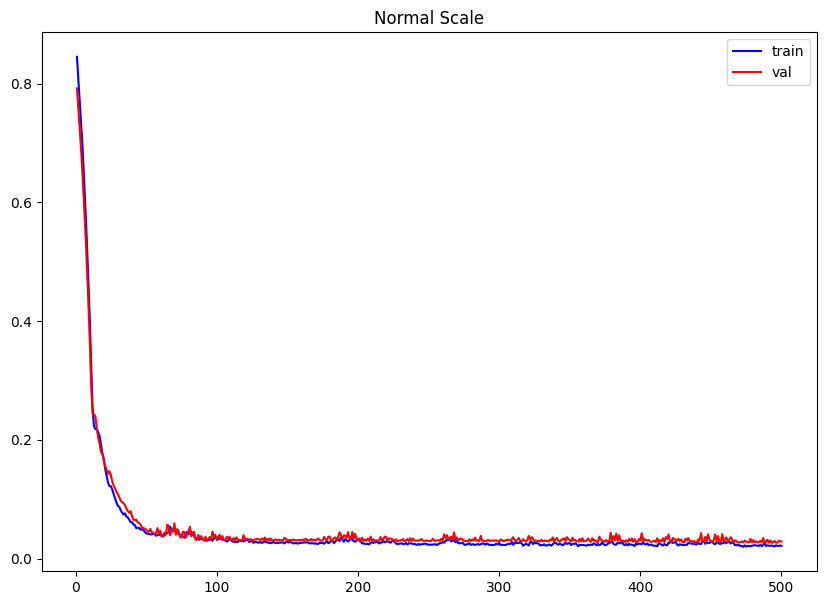

In [30]:
plt.figure(figsize = (10, 7))
plt.title('Normal Scale')
plt.plot(all_n_epochs, all_loss_train, color = 'blue', label = 'train')
plt.plot(all_n_epochs, all_loss_val, color = 'red', label = 'val')
plt.legend()
plt.show()

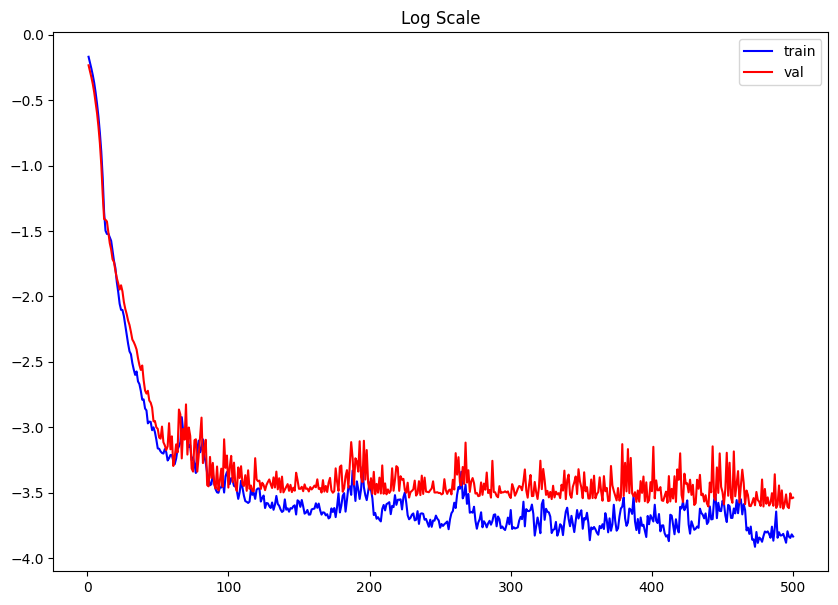

In [31]:
plt.figure(figsize = (10, 7))
plt.title('Log Scale')
plt.plot(all_n_epochs, np.log(all_loss_train), color = 'blue', label = 'train')
plt.plot(all_n_epochs, np.log(all_loss_val), color = 'red', label = 'val')
plt.legend()
plt.show()

### vi. Performance Metrics

In [32]:
X_train_col = X_train[:, 0]
y_train_predict = model(X_train).numpy()[:, 0]

df_train = pd.DataFrame()

df_train['X'] = X_train_col
df_train['y'] = y_train
df_train['y_predict'] = y_train_predict

df_train['X'] = df_train['X']*X_train_std[0] + X_train_mean[0]
df_train['y'] = df_train['y']*y_train_std + y_train_mean
df_train['y_predict'] = df_train['y_predict']*y_train_std + y_train_mean

In [33]:
X_val_col = X_val[:, 0]
y_val_predict = model(X_val).numpy()[:, 0]

df_val = pd.DataFrame()

df_val['X'] = X_val_col
df_val['y'] = y_val
df_val['y_predict'] = y_val_predict

df_val['X'] = df_val['X']*X_train_std[0] + X_train_mean[0]
df_val['y'] = df_val['y']*y_train_std + y_train_mean
df_val['y_predict'] = df_val['y_predict']*y_train_std + y_train_mean

In [34]:
X_test_col = X_test[:, 0]
y_test_predict = model(X_test).numpy()[:, 0]

df_test = pd.DataFrame()

df_test['X'] = X_test_col
df_test['y'] = y_test
df_test['y_predict'] = y_test_predict

df_test['X'] = df_test['X']*X_train_std[0] + X_train_mean[0]
df_test['y'] = df_test['y']*y_train_std + y_train_mean
df_test['y_predict'] = df_test['y_predict']*y_train_std + y_train_mean

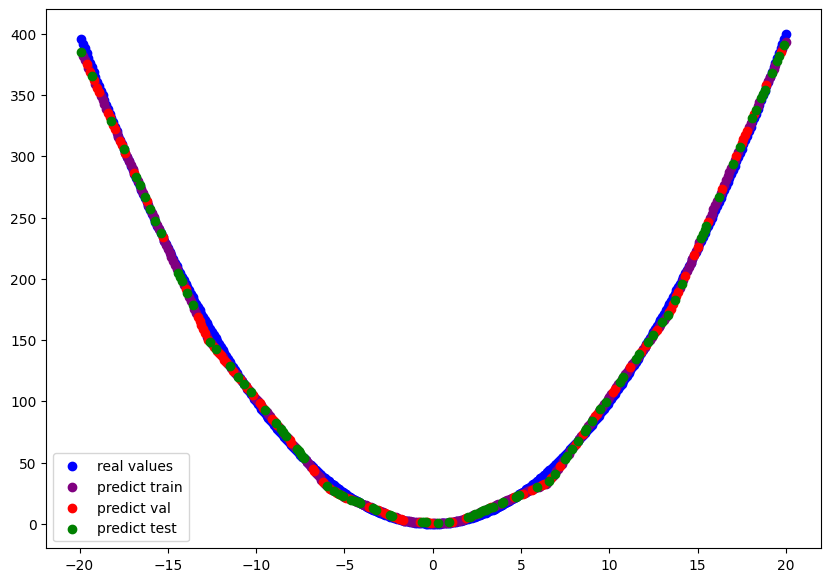

In [35]:
plt.figure(figsize = (10, 7))

plt.scatter(df_train['X'], df_train['y'], color = 'blue', label = 'real values')
plt.scatter(df_val['X'], df_val['y'], color = 'blue')
plt.scatter(df_test['X'], df_test['y'], color = 'blue')

plt.scatter(df_train['X'], df_train['y_predict'], color = 'purple', label = 'predict train')
plt.scatter(df_val['X'], df_val['y_predict'], color = 'red', label = 'predict val')
plt.scatter(df_test['X'], df_test['y_predict'], color = 'green', label = 'predict test')

plt.legend()
plt.show()

In [36]:
mae_train = round(abs(df_train['y_predict'] - df_train['y']).mean(), 2)
mae_val = round(abs(df_val['y_predict'] - df_val['y']).mean(), 2)
mae_test = round(abs(df_test['y_predict'] - df_test['y']).mean(), 2)

print('MAE train: ', mae_train)
print('MAE val: ', mae_val)
print('MAE test: ', mae_test)

MAE train:  2.5
MAE val:  3.45
MAE test:  2.61


### vii. Explainability

In [37]:
!pip install -q shap

In [38]:
import shap

In [39]:
def MLP_predict(df_X):

  y_pred = model(df_X).numpy()[:, 0]

  return y_pred

In [40]:
explainer = shap.KernelExplainer(MLP_predict, df_test[['X']])

In [41]:
shap_values = explainer.shap_values(df_test[['X']])

  0%|          | 0/100 [00:00<?, ?it/s]

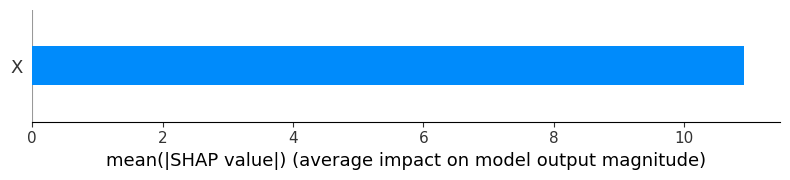

In [42]:
shap.summary_plot(shap_values, df_test[['X']], plot_type = "bar")

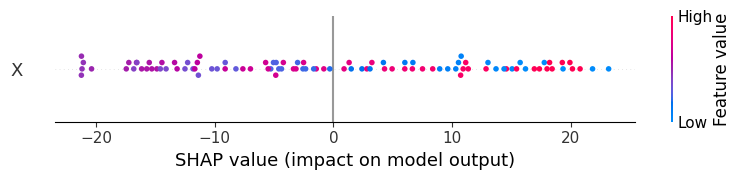

In [43]:
shap.summary_plot(shap_values, df_test[['X']])

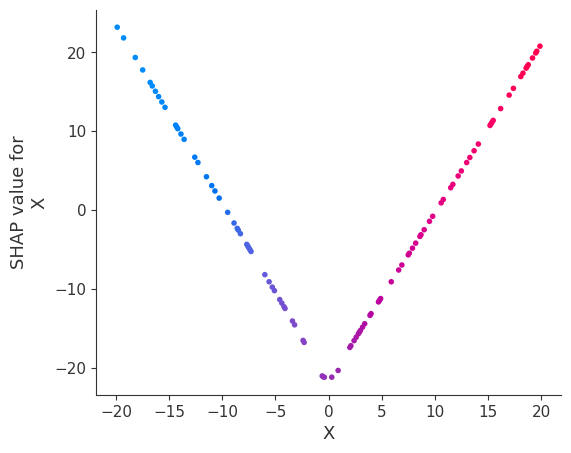

In [44]:
for name in ['X']:
    shap.dependence_plot(name, shap_values, df_test[['X']])

### End time of execution

In [45]:
end = time.time()

In [46]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 2 hours, 31 mins and 25 segs.
